  <a href="https://colab.research.google.com/github/marcpalo1999/MIA_sanidad/blob/main/2_2_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Aprendizaje Supervisado para Clasificación Médica: Predicción de Enfermedad Coronaria



 ## Objetivos

 En este script construiremos modelos de Machine Learning para clasificación médica usando el dataset de enfermedades cardíacas (nivel de estenosis coronaria) para predecir qué pacientes necesitan cateterismo cardíaco y cuales se lo pueden ahorrar.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, classification_report, roc_curve, auc)

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier



 ---

 # SECCIÓN 0: Cargar los datos

In [2]:
# Cargar el dataset
df = pd.read_csv("./data/heart_disease_dataset_con_nulos.csv")

print(f"Dataset cargado: {df.shape[0]} pacientes, {df.shape[1]} variables")
df.head()


Dataset cargado: 303 pacientes, 14 variables


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3.0,0.0,6.0,0.0
1,67,1,4,160,286,0,2,108,1,1.5,2.0,3.0,3.0,2.0
2,67,1,4,120,229,0,2,129,1,2.6,2.0,2.0,7.0,1.0
3,37,1,3,130,250,0,0,187,0,3.5,3.0,0.0,3.0,0.0
4,41,0,2,130,204,0,2,172,0,1.4,1.0,0.0,3.0,0.0


 # SECCIÓN 0.1: Resumen Descripción del Problema Clínico

 Para un entendimiento completo del problema, leed el archivo markdown adjunto titulado `2_2_ML_Explicación_Datos.md`.



 **Contexto del problema:**



 La secuencia diagnóstica actual para enfermedad coronaria es:

 1. Evaluación clínica (edad, síntomas, factores de riesgo)

 2. ECG en reposo

 3. Prueba de esfuerzo con ECG

      - Si es ambigua → Gammagrafía cardíaca (mínimamente invasiva), para descartar
         
         - si la gammagrafia es positiva vamos a cateterismo terapeutico
         - si es gammagrafia es negativa dejamos en seguimiento/profilaxis 

      - Si positiva → Cateterismo, primeramente diagnostico (INVASIVO, riesgos, coste alto ~3000€)



 **Problema clínico:**

 - Muchos pacientes se someten a cateterismo innecesariamente

 - El cateterismo tiene riesgos (2% complicaciones: hematomas, nefropatía, etc.)

 - Alto coste económico



 **Solución propuesta con ML:**

 Predecir el resultado del cateterismo usando solo las pruebas no invasivas previas,

 para reducir cateterismos innecesarios manteniendo alta sensibilidad (no perder casos reales de enfermedad).



 **Dos estrategias de modelado:**



 1. **Modelo Básico**: Solo consulta + ECG + prueba esfuerzo (aplicable a TODOS los pacientes)

    - Variables: edad, sexo, tipo dolor torácico, presión arterial, colesterol, ECG reposo, resultados prueba esfuerzo

    - Objetivo: Screening inicial para evitar cateterismos innecesarios



 2. **Modelo Completo**: Incluye gammagrafía (solo para casos equívocos)

    - Variables: todas las anteriores + resultado gammagrafía (thal)

    - Objetivo: Optimizar decisión cuando ya se realizó gammagrafía



 **Variable excluida por data leakage:**

 - `ca` (número de vasos obstruidos visualizados en fluoroscopia) se obtiene DURANTE el cateterismo

 - Usar `ca` para predecir `num` (resultado cateterismo) es circular, ya que ambas se miden simultáneamente

 - Incluirla sería como hacer trampa: predecir el resultado usando información del mismo procedimiento



 **Binarización del target:**

 - Variable original `num`: 0 (sin obstrucción coronatia), 1-4 (diferentes grados de obstruccion en diferentes cavidades)

 - Simplificamos a binario: 0 = no necesita cateterismo, 1 = necesita cateterismo

 - Razón clínica: la decisión es binaria (hacer/no hacer cateterismo), no gradual

 ---

 # SECCIÓN 1: Entendiendo el Problema desde ML



 **Tipo de problema:**

 - Supervised Learning: tenemos variable objetivo (target) para entrenar

 - Classification: la variable objetivo es categórica (enfermedad: sí/no)



 **Objetivo:** Dado un nuevo paciente con sus características clínicas, predecir si tiene

 enfermedad coronaria significativa que requiera cateterismo.

In [3]:
# Analizar variable objetivo 'num'
print("Distribución original de 'num':")
print(df['num'].value_counts().sort_index())

# Convertir a problema binario, ademas ya codificamos 0 como no enfermedad y 1 como enfermedad, no con strings, ya que si fuesen strings tendriamos que pasarlo a 0/1
df['target'] = (df['num'] > 0).astype(int)

print("\nDistribución binaria (target):")
print(df['target'].value_counts())
print(f"\nPrevalencia de enfermedad: {df['target'].mean()*100:.1f}%")


Distribución original de 'num':
num
0.0    151
1.0     55
2.0     36
3.0     34
4.0     11
Name: count, dtype: int64

Distribución binaria (target):
target
0    167
1    136
Name: count, dtype: int64

Prevalencia de enfermedad: 44.9%


 **Observación:** El dataset está relativamente balanceado (~45% con enfermedad).

 Esto es favorable para el aprendizaje del modelo, aunque no refleja la prevalencia

 real en screening poblacional (sería mucho menor). Estos pacientes ya fueron

 seleccionados para cateterismo basándose en criterio clínico previo.

 ---

 # SECCIÓN 2: Análisis Exploratorio Rápido

In [4]:
# Información general del dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     288 non-null    float64
 11  ca        284 non-null    float64
 12  thal      286 non-null    float64
 13  num       287 non-null    float64
 14  target    303 non-null    int64  
dtypes: float64(5), int64(10)
memory usage: 35.6 KB


In [5]:
# Revisar valores nulos
missing_counts = df.isna().sum().sort_values(ascending=False)
print("Número de missing values por columna:")
print(missing_counts)





Número de missing values por columna:
ca          19
thal        17
num         16
slope       15
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
target       0
dtype: int64


In [6]:
# Estadísticas descriptivas
df.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,288.000000,284.000000,286.000000,287.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.597222,0.683099,4.685315,0.951220,0.448845
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.622678,0.935138,1.930074,1.213728,0.498199
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000


 **Observaciones:**

 - Variables con diferentes escalas (edad: 29-77, colesterol: 126-564)

 - Algunas variables son categóricas codificadas como números

 - Presencia de valores faltantes que requieren manejo

 ## Verificación de duplicados - Evitar data leakage



 **Problema:** Si el mismo paciente aparece múltiples veces en el dataset, podría

 terminar en AMBOS conjuntos (train y test), causando data leakage severo.



 **Consecuencia:** El modelo "vería" al paciente durante el entrenamiento y luego

 lo "evaluaría" en el test, inflando artificialmente las métricas.



 **Solución:** Verificar que cada fila representa un paciente único.

In [7]:
# Verificar duplicados completos (filas idénticas)
duplicados_completos = df.duplicated().sum()

if duplicados_completos > 0:
    print(f"ALERTA: {duplicados_completos} filas duplicadas encontradas")
    df = df.drop_duplicates()
    print(f"Duplicados eliminados. Dataset: {df.shape[0]} pacientes")
else:
    print(f"OK: No hay duplicados ({df.shape[0]} pacientes únicos)")

# Verificar duplicados parciales basados en variables clave
columnas_clave = ['age', 'sex', 'trestbps', 'chol', 'thalach']
duplicados_parciales = df.duplicated(subset=columnas_clave).sum()

if duplicados_parciales > 0:
    print(f"ALERTA: {duplicados_parciales} posibles pacientes repetidos (verificar manualmente)")


OK: No hay duplicados (303 pacientes únicos)


 ---

 # SECCIÓN 3: Preprocesamiento - Parte 1: Codificación de Variables Categóricas



 Las variables categóricas necesitan One-Hot Encoding para ser interpretadas correctamente por parte de los modelos de ML.

 Sin él, el modelo pensaría que cp=4 es "mayor" que cp=2, lo cual puede tener sentido clinico en algunos casos (variables categoricas ordinales), pero no en todos.

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63,1,1,145,233,1,2,150,0,2.3,3.0,0.0,6.0,0.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2.0,3.0,3.0,2.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2.0,2.0,7.0,1.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3.0,0.0,3.0,0.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1.0,0.0,3.0,0.0,0


In [9]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num         float64
target        int64
dtype: object

Como podemos ver, los autores del dataset muy amablemente ya nos han codificado las variables categoricas ['cp', 'restecg', 'slope'] como numéricas. Entonces no tenemos que hacer el mapeo str -> int. Lo que una variable categorica de Ints puede ser un problema para un modelo de ML si realmente no es ordinal, ya que decidle al modelo que la variable tiene valores del 1 al 4, implicitamente le indica que la categoria 4 > 3 > 2 > 1. Para evitar este efecto indeseado (si fuese indeseado) se usa el one-hot encoding, que aplicaremos ahora.

In [10]:
# Variables categóricas en el dataset
categorical_cols = ['cp', 'restecg', 'slope']
categorical_cols = [col for col in categorical_cols if col in df.columns]

print(f"Variables categóricas identificadas: {categorical_cols}")
for col in categorical_cols:
    print(f"  {col}: {df[col].nunique()} categorías - valores: {sorted(df[col].unique())}")


Variables categóricas identificadas: ['cp', 'restecg', 'slope']
  cp: 4 categorías - valores: [1, 2, 3, 4]
  restecg: 3 categorías - valores: [0, 1, 2]
  slope: 3 categorías - valores: [1.0, 2.0, 3.0, nan]


In [11]:
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print(f"\nShape antes: {df.shape}")
print(f"Shape después: {df_encoded.shape}")
print(f"Columnas añadidas: {df_encoded.shape[1] - df.shape[1]}")

df_encoded.head()




Shape antes: (303, 15)
Shape después: (303, 19)
Columnas añadidas: 4


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,thal,num,target,cp_2,cp_3,cp_4,restecg_1,restecg_2,slope_2.0,slope_3.0
0,63,1,145,233,1,150,0,2.3,0.0,6.0,0.0,0,0,0,0,0,1,0,1
1,67,1,160,286,0,108,1,1.5,3.0,3.0,2.0,1,0,0,1,0,1,1,0
2,67,1,120,229,0,129,1,2.6,2.0,7.0,1.0,1,0,0,1,0,1,1,0
3,37,1,130,250,0,187,0,3.5,0.0,3.0,0.0,0,0,1,0,0,0,0,1
4,41,0,130,204,0,172,0,1.4,0.0,3.0,0.0,0,1,0,0,0,1,0,0


 ---

 # SECCIÓN 4: Definición de Estrategias de Modelado



 Implementaremos DOS estrategias según disponibilidad de datos clínicos.

In [12]:
# Variables disponibles (excluir target, num original, y ca por data leakage)
all_features = [col for col in df_encoded.columns if col not in ['target', 'num', 'ca']]

# ESTRATEGIA 1: Modelo Básico (sin gammagrafía thal, sin cateterismo ca)
basic_features = [col for col in all_features if not col.startswith('thal')]

# ESTRATEGIA 2: Modelo Completo (con gammagrafía thal, sin cateterismo ca)
complete_features = all_features.copy()

print(f"ESTRATEGIA 1 - Modelo Básico:")
print(f"  Total variables: {len(basic_features)}")
print(f"  Variables: {basic_features}\n")

print(f"ESTRATEGIA 2 - Modelo Completo:")
print(f"  Total variables: {len(complete_features)}")
print(f"  Variables añadidas: {[col for col in complete_features if col not in basic_features]}\n")

print(f"Variable EXCLUIDA (data leakage): 'ca'")


ESTRATEGIA 1 - Modelo Básico:
  Total variables: 14
  Variables: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'exang', 'oldpeak', 'cp_2', 'cp_3', 'cp_4', 'restecg_1', 'restecg_2', 'slope_2.0', 'slope_3.0']

ESTRATEGIA 2 - Modelo Completo:
  Total variables: 16
  Variables añadidas: ['thalach', 'thal']

Variable EXCLUIDA (data leakage): 'ca'


 ---

 # SECCIÓN 5: División Train/Test



 ## El problema fundamental del ML



 Si entrenamos y evaluamos en los mismos datos, el modelo memorizará en lugar de aprender.

 Como darle a un estudiante las preguntas del examen antes del examen.



 ## Solución: Train/Test Split



 - **Train set (80%):** Entrenar el modelo

 - **Test set (20%):** Completamente oculto, simula pacientes nuevos



 El test set se usa UNA SOLA VEZ al final para estimar performance real.

In [13]:
# Preparar datos
X = df_encoded[complete_features]
y = df_encoded['target']

# Verificar tipos numéricos
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"Eliminando columnas no numéricas: {non_numeric}")
    X = X.select_dtypes(include=[np.number])

# Train/Test Split (80/20) con estratificación para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Dimensiones X: {X.shape}")
print(f"Train: {X_train.shape[0]} pacientes ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} pacientes ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nVerificación de estratificación:")
print(f"  Enfermedad en Train: {y_train.mean()*100:.1f}%")
print(f"  Enfermedad en Test: {y_test.mean()*100:.1f}%")
print(f"  Enfermedad en Original: {y.mean()*100:.1f}%")


Dimensiones X: (303, 16)
Train: 242 pacientes (79.9%)
Test: 61 pacientes (20.1%)

Verificación de estratificación:
  Enfermedad en Train: 45.0%
  Enfermedad en Test: 44.3%
  Enfermedad en Original: 44.9%


 ---

 # SECCIÓN 6: Preprocesamiento - Parte 2: Valores Faltantes (DESPUÉS del split para evitar data leakage)



 ## Por qué DESPUÉS del split



 Los modelos ML no pueden trabajar con valores NaN. Usaremos mediana para imputación (robusta a outliers).



 **Flujo incorrecto:**

 1. Calcular mediana con todos los datos (train + test)

 2. Imputar valores faltantes

 3. Hacer train/test split



 **Problema:** La mediana fue calculada usando información del test set, causando data leakage.



 **Flujo correcto:**

 1. Hacer train/test split primero

 2. Calcular mediana SOLO con datos de train

 3. Aplicar esa mediana a train

 4. Aplicar la MISMA mediana (del train) al test



 **Analogía clínica:** Es como calcular valores de referencia de un test diagnóstico.

 Los valores de referencia se calculan con la población de desarrollo, NO incluyendo

 la población de validación. Luego se aplican esos mismos valores a la validación.

In [14]:
columns_with_nulls = X_train.columns[X_train.isnull().any()].tolist()

if len(columns_with_nulls) > 0:
    print(f"Variables con valores nulos: {columns_with_nulls}")
    print(f"\nValores nulos antes de imputación:")
    print(f"  Train: {X_train.isnull().sum().sum()}")
    print(f"  Test: {X_test.isnull().sum().sum()}")
    
    # Imputación con mediana calculada SOLO del train
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)  # Aprende SOLO de train
    
    X_train = pd.DataFrame(
        imputer.transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    X_test = pd.DataFrame(
        imputer.transform(X_test),  # Usa medianas del train
        columns=X_test.columns,
        index=X_test.index
    )
    
    print(f"\nValores nulos después de imputación:")
    print(f"  Train: {X_train.isnull().sum().sum()}")
    print(f"  Test: {X_test.isnull().sum().sum()}")
else:
    print("No hay valores nulos en train ni test")


Variables con valores nulos: ['thal']

Valores nulos antes de imputación:
  Train: 13
  Test: 4

Valores nulos después de imputación:
  Train: 0
  Test: 0


 ---

 # SECCIÓN 7: Escalado (DESPUÉS del split para evitar data leakage)



 ## Por qué escalar

 Las variables tienen escalas muy diferentes (edad: 29-77, colesterol: 126-564).

 Algunos algoritmos (Logistic Regression, KNN) son sensibles a estas diferencias, porque estan basados internamente en metricas de "distancia".



 ## StandardScaler

 Transforma a media=0, desviación estándar=1.



 ## Por qué DESPUÉS del split

 Si escalamos antes, calcularíamos estadísticas usando también el test set, lo cual sería data leakage.



 **Flujo correcto:**

 1. Split train/test

 2. Calcular media/std SOLO del train

 3. Aplicar transformación a ambos sets

In [18]:
scaler = StandardScaler()

# Fit en train (aprende media y std)
X_train_scaled = scaler.fit_transform(X_train)
# Transform en test (usa estadísticas del train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train_scaled.describe()



,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,thal,cp_2,cp_3,cp_4,restecg_1,restecg_2,slope_2.0,slope_3.0
count,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,242.000000,2.420000e+02,2.420000e+02,2.420000e+02
mean,-1.238679e-16,8.808381e-17,-5.285029e-16,-9.175397e-18,7.707333e-17,5.138222e-17,-8.808381e-17,-1.321257e-16,-9.175397e-17,3.670159e-18,1.339608e-16,-7.340318e-18,0.000000,7.340318e-18,5.505238e-17,4.220683e-17
std,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073e+00,1.002073,1.002073e+00,1.002073e+00,1.002073e+00
min,-2.831282e+00,-1.463850e+00,-2.111841e+00,-2.460889e+00,-4.248386e-01,-3.386952e+00,-7.027284e-01,-8.705925e-01,-8.267357e-01,-4.714045e-01,-6.059964e-01,-9.437293e-01,-0.112037,-1.016668e+00,-8.535640e-01,-2.570589e-01
25%,-7.379818e-01,-1.463850e+00,-6.673683e-01,-7.242894e-01,-4.248386e-01,-7.169668e-01,-7.027284e-01,-8.705925e-01,-8.267357e-01,-4.714045e-01,-6.059964e-01,-9.437293e-01,-0.112037,-1.016668e+00,-8.535640e-01,-2.570589e-01
50%,1.434079e-01,6.831301e-01,-1.118020e-01,-6.984386e-02,-4.248386e-01,1.658509e-01,-7.027284e-01,-3.531548e-01,-8.267357e-01,-4.714045e-01,-6.059964e-01,-9.437293e-01,-0.112037,9.836054e-01,-8.535640e-01,-2.570589e-01
75%,6.942765e-01,6.831301e-01,4.437643e-01,5.846016e-01,-4.248386e-01,7.041543e-01,1.423025e+00,5.092414e-01,1.262769e+00,-4.714045e-01,1.650175e+00,1.059626e+00,-0.112037,9.836054e-01,1.171558e+00,-2.570589e-01
max,2.457056e+00,6.831301e-01,3.777162e+00,3.537336e+00,2.353835e+00,2.254468e+00,1.423025e+00,4.476264e+00,1.262769e+00,2.121320e+00,1.650175e+00,1.059626e+00,8.925619,9.836054e-01,1.171558e+00,3.890159e+00


Efectivamente nuestras variables continuas ahora tienen media 0 y std 1

 ---

 # SECCIÓN 8: Modelo Baseline



 ## Por qué necesitamos un baseline



 Antes de construir modelos complejos, necesitamos un punto de referencia:

 el enfoque más simple posible.



 **DummyClassifier** siempre predice la clase más frecuente.

 Es nuestro "mínimo a superar".

In [19]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_scaled, y_train)

dummy_train_pred = dummy_clf.predict(X_train_scaled)
dummy_test_pred = dummy_clf.predict(X_test_scaled)

dummy_train_acc = accuracy_score(y_train, dummy_train_pred)
dummy_test_acc = accuracy_score(y_test, dummy_test_pred)

most_frequent_class = dummy_clf.classes_[np.argmax(dummy_clf.class_prior_)]

print(f"BASELINE MODEL (DummyClassifier)")
print(f"  Train Accuracy: {dummy_train_acc*100:.2f}%")
print(f"  Test Accuracy: {dummy_test_acc*100:.2f}%")
print(f"  Predicción: siempre {'Enfermedad' if most_frequent_class == 1 else 'Sin Enfermedad'}")
print(f"\nCualquier modelo ML debe superar {dummy_test_acc*100:.1f}% para ser útil")


BASELINE MODEL (DummyClassifier)
  Train Accuracy: 54.96%
  Test Accuracy: 55.74%
  Predicción: siempre Sin Enfermedad

Cualquier modelo ML debe superar 55.7% para ser útil


 ---

 # SECCIÓN 9: Entendiendo la Evaluación de Performance



 ## Tres formas de evaluar un modelo:

 En el fondo siempre que evaluamos un modelo la pregunta que nos hacemos es: Como de bien lo hará nuestro modelo en "produccion", es decir, cuando lo estemos usando en el departamento que le toque? Como no lo sabemos (porque aun no lo hemos puesto en producción), lo que intentamos es estimar lo mas precisamente posible como lo hará, y tres maneras de estimar este error en producción (aunque unas mejores que otras) son las siguientes:

 **A) Train Accuracy:** Detectar underfitting (modelo demasiado simple)



 **B) Test Accuracy:** Performance real (usar SOLO al final, UNA VEZ)



 **C) Cross-Validation:** Método preferido durante desarrollo del modelo



 Durante desarrollo usamos SOLO los datos de train para no "contaminar" el test set.

 El mismo ejercicio que estamos haciendo para la metrica de accuracy lo podriamos hacer para cualquier otra metrica de performance, somo sensitividad, especificidad etc.

In [24]:
# Demostración con Logistic Regression
demo_model = LogisticRegression(random_state=42, max_iter=1000)
demo_model.fit(X_train_scaled, y_train)

# A) Train Accuracy
train_pred = demo_model.predict(X_train_scaled)
train_acc = accuracy_score(y_train, train_pred)

# B) Test Accuracy
test_pred = demo_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)

# C) Cross-Validation
cv_scores = cross_val_score(demo_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("TRES FORMAS DE EVALUAR UN MODELO:\n")
print(f"A) TRAIN ACCURACY: {train_acc*100:.2f}%")
print("   El modelo 've' estos datos durante entrenamiento")
print("   Score alto NO garantiza funcionar en pacientes nuevos\n")

print(f"B) TEST ACCURACY: {test_acc*100:.2f}%")
print("   El modelo NUNCA vio estos datos")
print("   Estima performance real")
print("   Solo hacer esto UNA VEZ al final\n")

print(f"C) CROSS-VALIDATION (5-Fold):")
print(f"   Scores por fold: {[f'{s*100:.1f}%' for s in cv_scores]}")
print(f"   Media: {cv_scores.mean()*100:.2f}% (± {cv_scores.std()*100:.2f}%)")
print("   Usa solo training data (divide en 5 folds los datos de train)")
print("   Da múltiples estimaciones (más robusto)")
print("   Test set permanece intacto")
print("\nDurante desarrollo: USAR CROSS-VALIDATION")


TRES FORMAS DE EVALUAR UN MODELO:

A) TRAIN ACCURACY: 83.06%
   El modelo 've' estos datos durante entrenamiento
   Score alto NO garantiza funcionar en pacientes nuevos

B) TEST ACCURACY: 83.61%
   El modelo NUNCA vio estos datos
   Estima performance real
   Solo hacer esto UNA VEZ al final

C) CROSS-VALIDATION (5-Fold):
   Scores por fold: ['77.6%', '75.5%', '79.2%', '70.8%', '87.5%']
   Media: 78.11% (± 5.46%)
   Usa solo training data (divide en 5 folds los datos de train)
   Da múltiples estimaciones (más robusto)
   Test set permanece intacto

Durante desarrollo: USAR CROSS-VALIDATION


 **Regla de oro:**

 - Si Train >> CV: OVERFITTING

 - Si Train ≈ CV ≈ Test: GOOD GENERALIZATION

 - Durante desarrollo: Cross-Validation

 - Solo al final: Test (una vez)

 ---

 # SECCIÓN 10: ESTRATEGIA 1 - Modelo Básico (Sin Gammagrafía)



 Entrenamos modelos usando solo variables de consulta + prueba esfuerzo.

 Aplicable a TODOS los pacientes.

In [25]:
# Preparar datos para Modelo Básico
X_train_basic = X_train_scaled[basic_features]
X_test_basic = X_test_scaled[basic_features]

print(f"ESTRATEGIA 1: MODELO BÁSICO")
print(f"Variables usadas: {len(basic_features)} de {len(complete_features)} totales")
print(f"Excluidas: thal (gammagrafía), ca (cateterismo)")
print(f"Train: {X_train_basic.shape}, Test: {X_test_basic.shape}")


ESTRATEGIA 1: MODELO BÁSICO
Variables usadas: 14 de 16 totales
Excluidas: thal (gammagrafía), ca (cateterismo)
Train: (242, 14), Test: (61, 14)


In [26]:
# Modelo 1: Logistic Regression (Básico)
log_reg_basic = LogisticRegression(random_state=42, max_iter=1000)
log_reg_basic.fit(X_train_basic, y_train)

log_reg_basic_train = log_reg_basic.score(X_train_basic, y_train)
log_reg_basic_cv = cross_val_score(log_reg_basic, X_train_basic, y_train, cv=5, scoring='accuracy')

print("MODELO 1: LOGISTIC REGRESSION (Básico)")
print(f"Train: {log_reg_basic_train*100:.2f}% | CV: {log_reg_basic_cv.mean()*100:.2f}% (±{log_reg_basic_cv.std()*100:.2f}%) | Gap: {(log_reg_basic_train - log_reg_basic_cv.mean())*100:.2f}%")


MODELO 1: LOGISTIC REGRESSION (Básico)
Train: 79.75% | CV: 72.77% (±7.52%) | Gap: 6.98%


In [27]:
# Modelo 2: Decision Tree (Básico)
tree_basic = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_basic.fit(X_train_basic, y_train)

tree_basic_train = tree_basic.score(X_train_basic, y_train)
tree_basic_cv = cross_val_score(tree_basic, X_train_basic, y_train, cv=5, scoring='accuracy')

print("MODELO 2: DECISION TREE (Básico)")
print(f"Train: {tree_basic_train*100:.2f}% | CV: {tree_basic_cv.mean()*100:.2f}% (±{tree_basic_cv.std()*100:.2f}%) | Gap: {(tree_basic_train - tree_basic_cv.mean())*100:.2f}%")


MODELO 2: DECISION TREE (Básico)
Train: 88.02% | CV: 61.98% (±2.47%) | Gap: 26.04%


In [28]:
# Modelo 3: Random Forest (Básico)
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_basic.fit(X_train_basic, y_train)

rf_basic_train = rf_basic.score(X_train_basic, y_train)
rf_basic_cv = cross_val_score(rf_basic, X_train_basic, y_train, cv=5, scoring='accuracy')

print("MODELO 3: RANDOM FOREST (Básico)")
print(f"Train: {rf_basic_train*100:.2f}% | CV: {rf_basic_cv.mean()*100:.2f}% (±{rf_basic_cv.std()*100:.2f}%) | Gap: {(rf_basic_train - rf_basic_cv.mean())*100:.2f}%")


MODELO 3: RANDOM FOREST (Básico)
Train: 100.00% | CV: 71.95% (±8.19%) | Gap: 28.05%


In [29]:
# Modelo 4: KNN (Básico)
knn_basic = KNeighborsClassifier(n_neighbors=5)
knn_basic.fit(X_train_basic, y_train)

knn_basic_train = knn_basic.score(X_train_basic, y_train)
knn_basic_cv = cross_val_score(knn_basic, X_train_basic, y_train, cv=5, scoring='accuracy')

print("MODELO 4: K-NEAREST NEIGHBORS (Básico)")
print(f"Train: {knn_basic_train*100:.2f}% | CV: {knn_basic_cv.mean()*100:.2f}% (±{knn_basic_cv.std()*100:.2f}%) | Gap: {(knn_basic_train - knn_basic_cv.mean())*100:.2f}%")


MODELO 4: K-NEAREST NEIGHBORS (Básico)
Train: 81.40% | CV: 72.34% (±5.35%) | Gap: 9.07%


 ---

 # SECCIÓN 11: ESTRATEGIA 2 - Modelo Completo (Con Gammagrafía)



 Entrenamos modelos incluyendo resultado de gammagrafía.

 Solo aplicable a pacientes que ya tienen gammagrafía.

In [30]:
print(f"ESTRATEGIA 2: MODELO COMPLETO")
print(f"Variables usadas: {len(complete_features)}")
print(f"Incluye: thal (gammagrafía)")
print(f"Excluye: ca (cateterismo - data leakage)")
print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")


ESTRATEGIA 2: MODELO COMPLETO
Variables usadas: 16
Incluye: thal (gammagrafía)
Excluye: ca (cateterismo - data leakage)
Train: (242, 16), Test: (61, 16)


In [31]:
# Modelo 1: Logistic Regression (Completo)
log_reg_complete = LogisticRegression(random_state=42, max_iter=1000)
log_reg_complete.fit(X_train_scaled, y_train)

log_reg_complete_train = log_reg_complete.score(X_train_scaled, y_train)
log_reg_complete_cv = cross_val_score(log_reg_complete, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("MODELO 1: LOGISTIC REGRESSION (Completo)")
print(f"Train: {log_reg_complete_train*100:.2f}% | CV: {log_reg_complete_cv.mean()*100:.2f}% (±{log_reg_complete_cv.std()*100:.2f}%) | Gap: {(log_reg_complete_train - log_reg_complete_cv.mean())*100:.2f}%")


MODELO 1: LOGISTIC REGRESSION (Completo)
Train: 83.06% | CV: 78.11% (±5.46%) | Gap: 4.95%


In [32]:
# Modelo 2: Decision Tree (Completo)
tree_complete = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_complete.fit(X_train_scaled, y_train)

tree_complete_train = tree_complete.score(X_train_scaled, y_train)
tree_complete_cv = cross_val_score(tree_complete, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("MODELO 2: DECISION TREE (Completo)")
print(f"Train: {tree_complete_train*100:.2f}% | CV: {tree_complete_cv.mean()*100:.2f}% (±{tree_complete_cv.std()*100:.2f}%) | Gap: {(tree_complete_train - tree_complete_cv.mean())*100:.2f}%")


MODELO 2: DECISION TREE (Completo)
Train: 88.02% | CV: 66.16% (±4.30%) | Gap: 21.86%


In [33]:
# Modelo 3: Random Forest (Completo)
rf_complete = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_complete.fit(X_train_scaled, y_train)

rf_complete_train = rf_complete.score(X_train_scaled, y_train)
rf_complete_cv = cross_val_score(rf_complete, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("MODELO 3: RANDOM FOREST (Completo)")
print(f"Train: {rf_complete_train*100:.2f}% | CV: {rf_complete_cv.mean()*100:.2f}% (±{rf_complete_cv.std()*100:.2f}%) | Gap: {(rf_complete_train - rf_complete_cv.mean())*100:.2f}%")


MODELO 3: RANDOM FOREST (Completo)
Train: 100.00% | CV: 75.63% (±7.34%) | Gap: 24.37%


In [34]:
# Modelo 4: KNN (Completo)
knn_complete = KNeighborsClassifier(n_neighbors=5)
knn_complete.fit(X_train_scaled, y_train)

knn_complete_train = knn_complete.score(X_train_scaled, y_train)
knn_complete_cv = cross_val_score(knn_complete, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("MODELO 4: K-NEAREST NEIGHBORS (Completo)")
print(f"Train: {knn_complete_train*100:.2f}% | CV: {knn_complete_cv.mean()*100:.2f}% (±{knn_complete_cv.std()*100:.2f}%) | Gap: {(knn_complete_train - knn_complete_cv.mean())*100:.2f}%")


MODELO 4: K-NEAREST NEIGHBORS (Completo)
Train: 82.64% | CV: 74.84% (±8.29%) | Gap: 7.81%


 ---

 # SECCIÓN 12: Comparación de Estrategias

In [35]:
# Tabla comparativa
comparison = pd.DataFrame({
    'Modelo': ['Baseline', 
               'LogReg (Básico)', 'Tree (Básico)', 'RF (Básico)', 'KNN (Básico)',
               'LogReg (Completo)', 'Tree (Completo)', 'RF (Completo)', 'KNN (Completo)'],
    'Estrategia': ['N/A',
                   'Básico', 'Básico', 'Básico', 'Básico',
                   'Completo', 'Completo', 'Completo', 'Completo'],
    'Train (%)': [dummy_train_acc*100,
                  log_reg_basic_train*100, tree_basic_train*100, rf_basic_train*100, knn_basic_train*100,
                  log_reg_complete_train*100, tree_complete_train*100, rf_complete_train*100, knn_complete_train*100],
    'CV (%)': [dummy_test_acc*100,
               log_reg_basic_cv.mean()*100, tree_basic_cv.mean()*100, rf_basic_cv.mean()*100, knn_basic_cv.mean()*100,
               log_reg_complete_cv.mean()*100, tree_complete_cv.mean()*100, rf_complete_cv.mean()*100, knn_complete_cv.mean()*100],
    'Gap (%)': [0,
                (log_reg_basic_train - log_reg_basic_cv.mean())*100,
                (tree_basic_train - tree_basic_cv.mean())*100,
                (rf_basic_train - rf_basic_cv.mean())*100,
                (knn_basic_train - knn_basic_cv.mean())*100,
                (log_reg_complete_train - log_reg_complete_cv.mean())*100,
                (tree_complete_train - tree_complete_cv.mean())*100,
                (rf_complete_train - rf_complete_cv.mean())*100,
                (knn_complete_train - knn_complete_cv.mean())*100]
})

print("COMPARACIÓN COMPLETA: BÁSICO vs COMPLETO")
print(comparison.to_string(index=False))


COMPARACIÓN COMPLETA: BÁSICO vs COMPLETO
           Modelo Estrategia  Train (%)    CV (%)   Gap (%)
         Baseline        N/A  54.958678 55.737705  0.000000
  LogReg (Básico)     Básico  79.752066 72.772109  6.979957
    Tree (Básico)     Básico  88.016529 61.981293 26.035236
      RF (Básico)     Básico 100.000000 71.947279 28.052721
     KNN (Básico)     Básico  81.404959 72.338435  9.066523
LogReg (Completo)   Completo  83.057851 78.112245  4.945606
  Tree (Completo)   Completo  88.016529 66.156463 21.860066
    RF (Completo)   Completo 100.000000 75.629252 24.370748
   KNN (Completo)   Completo  82.644628 74.838435  7.806193


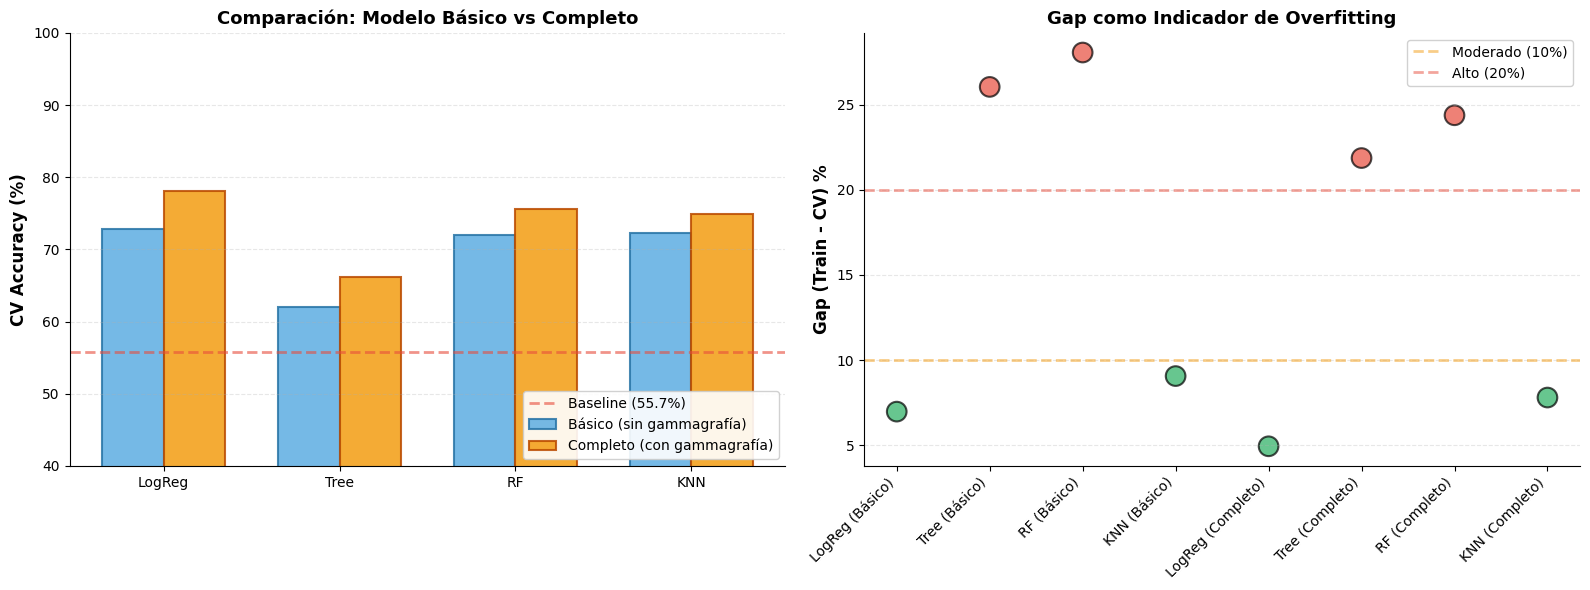

In [36]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

basic_models = comparison[comparison['Estrategia'] == 'Básico']
complete_models = comparison[comparison['Estrategia'] == 'Completo']

x = np.arange(4)
width = 0.35

color_basic = '#5DADE2'
color_complete = '#F39C12'

axes[0].bar(x - width/2, basic_models['CV (%)'].values, width, 
            label='Básico (sin gammagrafía)', alpha=0.85, color=color_basic, edgecolor='#2874A6', linewidth=1.5)
axes[0].bar(x + width/2, complete_models['CV (%)'].values, width,
            label='Completo (con gammagrafía)', alpha=0.85, color=color_complete, edgecolor='#BA4A00', linewidth=1.5)
axes[0].set_ylabel('CV Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación: Modelo Básico vs Completo', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['LogReg', 'Tree', 'RF', 'KNN'])
axes[0].axhline(y=dummy_test_acc*100, color='#E74C3C', linestyle='--', alpha=0.6, linewidth=2, 
                label=f'Baseline ({dummy_test_acc*100:.1f}%)')
axes[0].legend(framealpha=0.9, loc='lower right')
axes[0].set_ylim([40, 100])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

all_models = comparison[comparison['Estrategia'] != 'N/A']
colors_gap = ['#27AE60' if gap < 10 else '#F39C12' if gap < 20 else '#E74C3C' for gap in all_models['Gap (%)']]

axes[1].scatter(range(len(all_models)), all_models['Gap (%)'], 
                c=colors_gap, s=200, alpha=0.7, edgecolors='black', linewidth=1.5)

axes[1].axhline(y=10, color='#F39C12', linestyle='--', alpha=0.5, linewidth=2, label='Moderado (10%)')
axes[1].axhline(y=20, color='#E74C3C', linestyle='--', alpha=0.5, linewidth=2, label='Alto (20%)')

axes[1].set_ylabel('Gap (Train - CV) %', fontsize=12, fontweight='bold')
axes[1].set_title('Gap como Indicador de Overfitting', fontweight='bold', fontsize=13)
axes[1].set_xticks(range(len(all_models)))
axes[1].set_xticklabels(all_models['Modelo'], rotation=45, ha='right')
axes[1].legend(framealpha=0.9)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


 **Observaciones:**

 - Todos los modelos superan el baseline

 - Modelos Completos (con gammagrafía) tienen mejor accuracy: Esperable, puesto que usan también una información valiosa que el modelo basico no usa...

 - Random Forest muestra mejor balance en ambas estrategias

 ---

 # SECCIÓN 13: Métricas Clínicas - Evaluación en Test Set



 ## Métricas que importan en medicina:

 Como me habreis oido decir antes, la accuracy no lo es todo, puesto que si el coste monetario o humano de un FP y un FN no son parecidos, no nos ayuda a encontrar un buen compromiso, de la misma manera que también nos engaña si predecimos sobre enfermedades con muy poca prevalencia (nuestros datos estan muy desbalanceados)

 **Sensitivity (Recall):** De todos los enfermos, ¿cuántos detectamos?

 - En medicina: NO queremos perder casos de enfermedad (priorizar Sensitivity)



 **Specificity:** De todos los sanos, ¿cuántos identificamos correctamente?

 - Evita procedimientos innecesarios



 **PPV (Precision):** Si predecimos "enfermedad", ¿qué probabilidad de estar en lo cierto?



 **NPV:** Si predecimos "sano", ¿qué probabilidad de estar en lo cierto?



 Evaluamos SOLO EN TEST SET (una única vez)

In [37]:
def clinical_metrics(y_true, y_pred, model_name):
    """Calcula métricas clínicas relevantes"""
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    print(f"\nMÉTRICAS CLÍNICAS: {model_name}")
    print(f"{'='*70}")
    print(f"\nConfusion Matrix:")
    print(f"  TN: {TN} (sanos identificados correctamente)")
    print(f"  FP: {FP} (sanos clasificados como enfermos - cateterismo innecesario)")
    print(f"  FN: {FN} (enfermos clasificados como sanos - PELIGROSO)")
    print(f"  TP: {TP} (enfermos identificados correctamente)")
    
    print(f"\nMÉTRICAS:")
    print(f"  Accuracy: {accuracy*100:.1f}%")
    print(f"  Sensitivity (Recall): {sensitivity*100:.1f}% - Detecta {sensitivity*100:.0f}% de enfermos")
    print(f"  Specificity: {specificity*100:.1f}% - Identifica {specificity*100:.0f}% de sanos")
    print(f"  PPV (Precision): {ppv*100:.1f}% - Si predice enfermedad, {ppv*100:.0f}% correcto")
    print(f"  NPV: {npv*100:.1f}% - Si predice sano, {npv*100:.0f}% correcto")
    
    print(f"\nCASOS PERDIDOS: {FN} pacientes con enfermedad NO detectados")
    
    return {
        'Model': model_name,
        'Sensitivity': sensitivity * 100,
        'Specificity': specificity * 100,
        'PPV': ppv * 100,
        'NPV': npv * 100,
        'Accuracy': accuracy * 100,
        'FN': FN,
        'FP': FP
    }


In [39]:
# Evaluar Random Forest Básico en Test
print("EVALUACIÓN FINAL EN TEST SET")

y_pred_rf_basic = rf_basic.predict(X_test_basic)
metrics_rf_basic = clinical_metrics(y_test, y_pred_rf_basic, "Random Forest (Básico)")


EVALUACIÓN FINAL EN TEST SET

MÉTRICAS CLÍNICAS: Random Forest (Básico)

Confusion Matrix:
  TN: 27 (sanos identificados correctamente)
  FP: 7 (sanos clasificados como enfermos - cateterismo innecesario)
  FN: 2 (enfermos clasificados como sanos - PELIGROSO)
  TP: 25 (enfermos identificados correctamente)

MÉTRICAS:
  Accuracy: 85.2%
  Sensitivity (Recall): 92.6% - Detecta 93% de enfermos
  Specificity: 79.4% - Identifica 79% de sanos
  PPV (Precision): 78.1% - Si predice enfermedad, 78% correcto
  NPV: 93.1% - Si predice sano, 93% correcto

CASOS PERDIDOS: 2 pacientes con enfermedad NO detectados


In [40]:
# Evaluar Random Forest Completo en Test
y_pred_rf_complete = rf_complete.predict(X_test_scaled)
metrics_rf_complete = clinical_metrics(y_test, y_pred_rf_complete, "Random Forest (Completo)")



MÉTRICAS CLÍNICAS: Random Forest (Completo)

Confusion Matrix:
  TN: 30 (sanos identificados correctamente)
  FP: 4 (sanos clasificados como enfermos - cateterismo innecesario)
  FN: 5 (enfermos clasificados como sanos - PELIGROSO)
  TP: 22 (enfermos identificados correctamente)

MÉTRICAS:
  Accuracy: 85.2%
  Sensitivity (Recall): 81.5% - Detecta 81% de enfermos
  Specificity: 88.2% - Identifica 88% de sanos
  PPV (Precision): 84.6% - Si predice enfermedad, 85% correcto
  NPV: 85.7% - Si predice sano, 86% correcto

CASOS PERDIDOS: 5 pacientes con enfermedad NO detectados


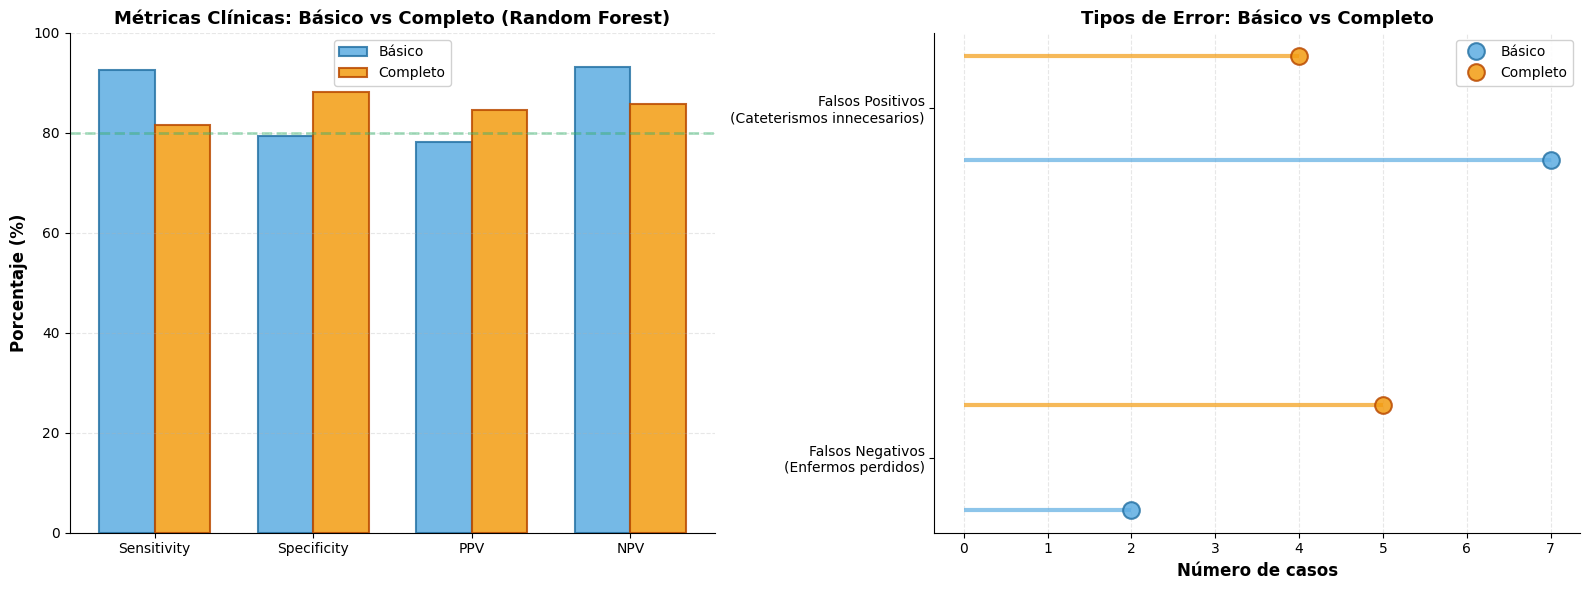

In [41]:
# Comparación visual de métricas
metrics_comparison = pd.DataFrame([metrics_rf_basic, metrics_rf_complete])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics_to_plot = ['Sensitivity', 'Specificity', 'PPV', 'NPV']
x = np.arange(len(metrics_to_plot))
width = 0.35

basic_vals = [metrics_rf_basic[m] for m in metrics_to_plot]
complete_vals = [metrics_rf_complete[m] for m in metrics_to_plot]

color_basic = '#5DADE2'
color_complete = '#F39C12'

axes[0].bar(x - width/2, basic_vals, width, label='Básico', alpha=0.85, 
            color=color_basic, edgecolor='#2874A6', linewidth=1.5)
axes[0].bar(x + width/2, complete_vals, width, label='Completo', alpha=0.85, 
            color=color_complete, edgecolor='#BA4A00', linewidth=1.5)
axes[0].set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Métricas Clínicas: Básico vs Completo (Random Forest)', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend(framealpha=0.9)
axes[0].set_ylim([0, 100])
axes[0].axhline(y=80, color='#27AE60', linestyle='--', alpha=0.4, linewidth=2)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

error_types = ['Falsos Negativos\n(Enfermos perdidos)', 'Falsos Positivos\n(Cateterismos innecesarios)']
basic_errors = [metrics_rf_basic['FN'], metrics_rf_basic['FP']]
complete_errors = [metrics_rf_complete['FN'], metrics_rf_complete['FP']]

x2 = np.arange(len(error_types))

axes[1].hlines(y=x2 - 0.15, xmin=0, xmax=basic_errors, color=color_basic, alpha=0.7, linewidth=3)
axes[1].plot(basic_errors, x2 - 0.15, "o", markersize=12, color=color_basic, 
             alpha=0.85, label='Básico', markeredgecolor='#2874A6', markeredgewidth=1.5)

axes[1].hlines(y=x2 + 0.15, xmin=0, xmax=complete_errors, color=color_complete, alpha=0.7, linewidth=3)
axes[1].plot(complete_errors, x2 + 0.15, "o", markersize=12, color=color_complete, 
             alpha=0.85, label='Completo', markeredgecolor='#BA4A00', markeredgewidth=1.5)

axes[1].set_xlabel('Número de casos', fontsize=12, fontweight='bold')
axes[1].set_title('Tipos de Error: Básico vs Completo', fontweight='bold', fontsize=13)
axes[1].set_yticks(x2)
axes[1].set_yticklabels(error_types)
axes[1].legend(framealpha=0.9)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


 ---

 # SECCIÓN 14: Curvas ROC y Análisis de Threshold



 ## Por qué importa el threshold



 Los modelos de clasificación devuelven una probabilidad de enfermedad (0 a 1).

 Necesitamos un umbral de decisión (threshold) para convertir esa probabilidad en una decisión binaria. Hasta ahora automatiamente el codigo habia usado un thrshold de 0.5 para binarizar nuestra prediction (que es una probabilidad entre 0 y 1) a un resultado (sano/enfermo)



 **Threshold por defecto: 0.5**

 - Si probabilidad >= 0.5, predecir "enfermedad"

 - Si probabilidad < 0.5, predecir "sano"



 **Problema:** Este 0.5 es arbitrario y puede no ser óptimo para decisiones clínicas.



 **En medicina:**

 - **Threshold bajo (ej: 0.3):** Más sensible, detecta más enfermos, pero más falsos positivos

 - **Threshold alto (ej: 0.7):** Más específico, menos falsos positivos, pero pierde casos reales



 La **curva ROC** muestra el trade-off entre sensibilidad y especificidad para TODOS los thresholds posibles. 
 
 **Importante: Deberemos identificar el threshold que es más util para nuestras necesidades clínicas**

Alerta: El modelo ya lo habiamos entrenado antes y escogido en train, cogiendo el que tenia mejor accuracy en cross-validation en TRAIN. Ahora todo lo estamos comprobando en TEST.

In [44]:
# Obtener probabilidades predichas
y_proba_rf_basic = rf_basic.predict_proba(X_test_basic)[:, 1]
fpr_basic, tpr_basic, thresholds_basic = roc_curve(y_test, y_proba_rf_basic)
auc_basic = auc(fpr_basic, tpr_basic)

y_proba_rf_complete = rf_complete.predict_proba(X_test_scaled)[:, 1]
fpr_complete, tpr_complete, thresholds_complete = roc_curve(y_test, y_proba_rf_complete)
auc_complete = auc(fpr_complete, tpr_complete)

print(f"AUC Modelo Básico: {auc_basic:.3f}")
print(f"AUC Modelo Completo: {auc_complete:.3f}")


AUC Modelo Básico: 0.927
AUC Modelo Completo: 0.924


ROC-AUC es una metrica de performance threshold acnostic, es decir, a diferencia de la accuracy, senstivity etc., AUC no depende de que threshold escojamos, sinó que nos da una intuicion de lo bien que lo hace el modelo en general.

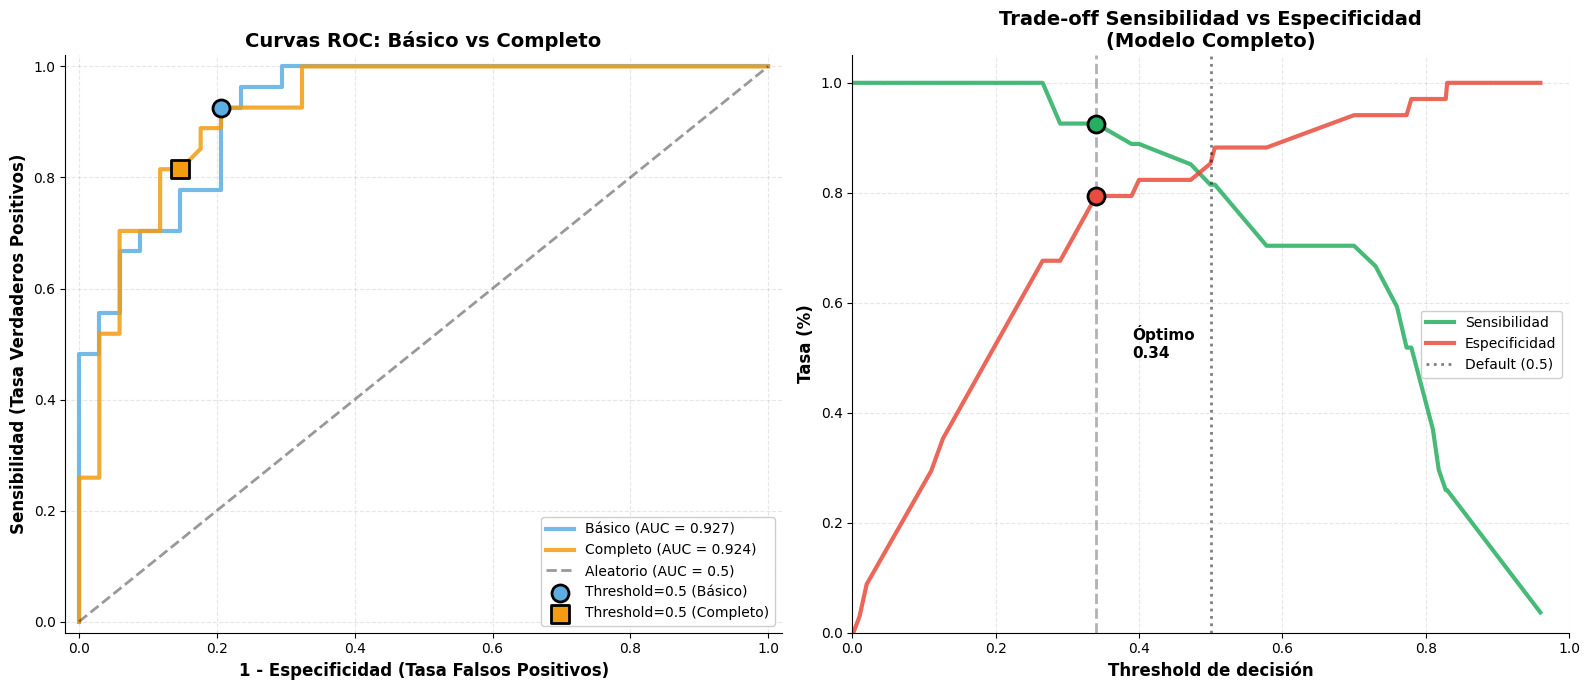


Threshold óptimo (Youden's Index): 0.340
Sensibilidad en threshold óptimo: 92.6%
Especificidad en threshold óptimo: 79.4%


In [45]:
# Visualización: Curvas ROC
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

color_basic = '#5DADE2'
color_complete = '#F39C12'

axes[0].plot(fpr_basic, tpr_basic, linewidth=3, color=color_basic, alpha=0.85,
             label=f'Básico (AUC = {auc_basic:.3f})')
axes[0].plot(fpr_complete, tpr_complete, linewidth=3, color=color_complete, alpha=0.85,
             label=f'Completo (AUC = {auc_complete:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.4, label='Aleatorio (AUC = 0.5)')

idx_basic_05 = np.argmin(np.abs(thresholds_basic - 0.5))
axes[0].scatter(fpr_basic[idx_basic_05], tpr_basic[idx_basic_05], 
                s=150, c=color_basic, edgecolors='black', linewidth=2, zorder=5,
                marker='o', label=f'Threshold=0.5 (Básico)')

idx_complete_05 = np.argmin(np.abs(thresholds_complete - 0.5))
axes[0].scatter(fpr_complete[idx_complete_05], tpr_complete[idx_complete_05], 
                s=150, c=color_complete, edgecolors='black', linewidth=2, zorder=5,
                marker='s', label=f'Threshold=0.5 (Completo)')

axes[0].set_xlabel('1 - Especificidad (Tasa Falsos Positivos)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sensibilidad (Tasa Verdaderos Positivos)', fontsize=12, fontweight='bold')
axes[0].set_title('Curvas ROC: Básico vs Completo', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', framealpha=0.95, fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_xlim([-0.02, 1.02])
axes[0].set_ylim([-0.02, 1.02])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

specificity_complete = 1 - fpr_complete

youden_idx = np.argmax(tpr_complete - fpr_complete)
optimal_threshold = thresholds_complete[youden_idx]

axes[1].plot(thresholds_complete, tpr_complete, linewidth=3, color='#27AE60', 
             alpha=0.85, label='Sensibilidad')
axes[1].plot(thresholds_complete, specificity_complete, linewidth=3, color='#E74C3C', 
             alpha=0.85, label='Especificidad')

axes[1].axvline(optimal_threshold, color='gray', linestyle='--', linewidth=2, alpha=0.6)
axes[1].scatter(optimal_threshold, tpr_complete[youden_idx], s=150, c='#27AE60', 
                edgecolors='black', linewidth=2, zorder=5)
axes[1].scatter(optimal_threshold, specificity_complete[youden_idx], s=150, c='#E74C3C', 
                edgecolors='black', linewidth=2, zorder=5)
axes[1].text(optimal_threshold + 0.05, 0.5, f'Óptimo\n{optimal_threshold:.2f}', 
             fontsize=11, fontweight='bold', ha='left')

axes[1].axvline(0.5, color='black', linestyle=':', linewidth=2, alpha=0.5, label='Default (0.5)')

axes[1].set_xlabel('Threshold de decisión', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Tasa (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Trade-off Sensibilidad vs Especificidad\n(Modelo Completo)', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc='best', framealpha=0.95, fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\nThreshold óptimo (Youden's Index): {optimal_threshold:.3f}")
print(f"Sensibilidad en threshold óptimo: {tpr_complete[youden_idx]*100:.1f}%")
print(f"Especificidad en threshold óptimo: {specificity_complete[youden_idx]*100:.1f}%")


 **Interpretación de las curvas ROC:**



 - **AUC (Area Under Curve):** Métrica global de performance

   - AUC = 0.5: Modelo aleatorio (línea diagonal)

   - AUC = 1.0: Modelo perfecto (esquina superior izquierda)

   - AUC > 0.8: Generalmente considerado bueno en medicina



 - **Threshold óptimo (Youden's Index):** Maximiza (Sensibilidad + Especificidad - 1)

   - Balancea ambas métricas igualmente

   - Puede no ser óptimo si hay costes asimétricos (FN vs FP)



 - **En nuestro contexto clínico:**

   - FN (enfermo no detectado) es MÁS grave que FP (cateterismo innecesario)

   - Podríamos preferir threshold < 0.5 para aumentar sensibilidad

   - Trade-off: Más cateterismos pero menos casos perdidos

In [46]:
# Análisis de diferentes thresholds
thresholds_to_test = np.linspace(0,1, num=51)
results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_proba_rf_complete >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_threshold)
    TN, FP, FN, TP = cm.ravel()
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    
    results.append({
        'Threshold': threshold,
        'Sensitivity': sensitivity * 100,
        'Specificity': specificity * 100,
        'Accuracy': (TP + TN) / (TP + TN + FP + FN) * 100,
        'PPV': ppv * 100,
        'NPV': npv * 100,
        'FN': FN,
        'FP': FP,
        'TN': TN,
        'Total_Errors': FN + FP
    })

results_df = pd.DataFrame(results)
print("\nAnálisis de diferentes thresholds (Modelo Completo):")
print(results_df.round(3).to_string(index=False))




Análisis de diferentes thresholds (Modelo Completo):
 Threshold  Sensitivity  Specificity  Accuracy     PPV     NPV  FN  FP  TN  Total_Errors
      0.00      100.000        0.000    44.262  44.262   0.000   0  34   0            34
      0.02      100.000        8.824    49.180  46.552 100.000   0  31   3            31
      0.04      100.000       11.765    50.820  47.368 100.000   0  30   4            30
      0.06      100.000       17.647    54.098  49.091 100.000   0  28   6            28
      0.08      100.000       23.529    57.377  50.943 100.000   0  26   8            26
      0.10      100.000       29.412    60.656  52.941 100.000   0  24  10            24
      0.12      100.000       35.294    63.934  55.102 100.000   0  22  12            22
      0.14      100.000       41.176    67.213  57.447 100.000   0  20  14            20
      0.16      100.000       41.176    67.213  57.447 100.000   0  20  14            20
      0.18      100.000       44.118    68.852  58.696 1

 **Interpretación clínica de los thresholds:**

 Gracias a esta visualización, ahora podremos escoger el threshold que nos de unas metricas más utiles para nuestras necesidades.


 **Decisión clínica:**

 En nuestro caso, que no nos podemos permitir perder casos de enfermedad,

 un threshold alrededor de 0.26 podría ser el más apropiado, puesto que no estariamos pasando por alto ningun positivo, y estamos descartando un ~64% de pacientes sanos que ya no tendrán que hacerse el cateterismo.

 Evidentemente todo esto se tendria que testear en un entorno clínico real para ver si los resultados se mantienen. (En un dataset de validación externa)

 ## Victoria!

# SECCIÓN 15: Importancia de las variables (Si hay tiempo)



# SECCIÓN 16: Entrenamiento final.

Ahora que ya tenemos el mejor modelo y el mejor threshold, podemos entrenarlo con todos los datos, guardarlo y ponerlo en producción!

 ---

 # FIN DEL SCRIPT



 ## Conceptos Cubiertos:

 - Preparación de datos completa (missing values, encoding, scaling)

 - Identificación y manejo de data leakage (variable `ca`, pacientes repetidos)

 - **CRÍTICO: Imputación y escalado DESPUÉS del split para evitar data leakage**

 - Dos estrategias de modelado (Básico vs Completo)

 - Train/Test Split y Cross-Validation

 - Modelos baseline y 4 algoritmos de clasificación

 - Evaluación correcta (Train/Test/CV)

 - Métricas clínicas (Sensitivity, Specificity, PPV, NPV)

 - Curvas ROC y análisis de threshold

 - Impacto clínico real (ahorro económico, reducción de complicaciones)

 - Trade-offs clínicos (casos detectados vs procedimientos evitados)